In [1]:
# SPDX-License-Identifier: GPL-3.0-or-later

In [2]:
%matplotlib widget

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from scipy.stats import linregress
import matplotlib
font = {'size'   : 12}

matplotlib.rc('font', **font)
import conntility


# Samples cells from exemplary regions and gets scaling factors

In [42]:
import bluepysnap as bp
s = bp.Simulation('/gpfs/bbp.cscs.ch/project/proj83/scratch/home/tharayil/BlueRecording/examples/whiskerFlick/data/simulation/simulation_config.json')
circuit = s.circuit

In [43]:
nodes = circuit.nodes

In [44]:
# Loads a generator that produces the cell types for all cells in forelimb, hindlimb, and upper lip regions

nFl = nodes.get('S1FL',properties=['mtype'])


In [45]:
# Loads node ids for Layer 5 TPC:A cells from each of the above regions

Fl = next(nFl)[1]
Fl = np.array(list(Fl[Fl['mtype']=='L5_TPC:A'].index))[:,1].astype(int)



In [46]:
import h5py

In [47]:
# Loads the weights file

coeffsFile = "/gpfs/bbp.cscs.ch/project/proj83/scratch/home/tharayil/BlueRecording/examples/whiskerFlick/electrodeFile/coeffs_eeg.h5"

coeffs = h5py.File(coeffsFile)

In [48]:
# Node ids from weights file
allNodeIds = coeffs['S1nonbarrel_neurons']['node_ids']

In [49]:
# Finds indices in the weights file of nodes in the selected regions

flIndex = np.where(np.isin(allNodeIds[:],Fl))[0]



In [50]:
np.random.seed(1776)

# Samples nodes from the selected regions

flIndex = np.sort(np.random.choice(flIndex,1000,replace=False))


FLshort = allNodeIds[:][flIndex]



In [51]:
# Finds offsets for the compartment weights for the selected nodes

flOffsets = [coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex],coeffs['S1nonbarrel_neurons']['offsets'][:][flIndex+1]]



In [61]:
# Gets compartment weights for the selected nodes (shifted such that the minimum weight for each neuron is 0)

scaleFacFl = []


for i in range(len(flOffsets[0])):
    
    sfl = coeffs['electrodes']['S1nonbarrel_neurons']['scaling_factors'][flOffsets[0][i]:flOffsets[1][i]][:,0]
    sfl -= np.min(sfl)

    scaleFacFl.append( sfl )


In [60]:
sfl

array([0., 0., 0., ..., 0., 0., 0.])

# Loads 3d positions

In [18]:
path_to_positions = "compartment/c6374a94-59b9-468d-8958-f7c8f876e562/0/positions/"


In [19]:
# Loads positions for a subset of the selected nodes

allIds = [FLshort]

allIds = [s for item in allIds for s in item]

allIds = np.array(allIds)

import os

i = 0

for subfolder in os.listdir(path_to_positions):
    for file in os.listdir(path_to_positions+subfolder):
        
        if i > 10:
            break
        
        positions = pd.read_pickle(path_to_positions+subfolder+'/'+file)
        
        columns = np.array(list(positions.columns))[:,0]
        
        indices = np.where(np.isin(allIds,columns))[0]
        
        if len(indices)==0:
            continue
        
        idsInFile = allIds[indices]

        positions = positions[idsInFile]
        
        if i == 0:
            allPositions = positions
        else:
            allPositions = pd.concat((allPositions,positions),axis=1)
            
        i += 1
        

In [20]:
ids = np.unique(np.array(list(allPositions.columns))[:,0])

In [21]:
def getNeuronSegmentMidpts(position):
    '''
    Gets midpoints for a single neuron
    '''

    
    secIds = np.array(list(position.columns))
    uniqueSecIds = np.unique(secIds)

    for sId in uniqueSecIds: # Iterates through sections

        pos = position.iloc[:,np.where(sId == secIds)[0]]

        if sId == 0: # Implies that section is a soma, so we just take the position from the file

            newPos = pos
 
        elif np.shape(pos.values)[-1] == 1: # If there is only one point in the section, we just take the value
            newPos = pd.concat((newPos,pos),axis=1)

        else: # We take the midpoints of the values in the file, which are the endpoints of the segments
            pos = (pos.iloc[:,:-1]+pos.iloc[:,1:])/2

            newPos = pd.concat((newPos,pos),axis=1)

    return newPos

In [22]:
# Spatial positions of the electrodes

# ecog = np.array([3996,-777,-308.95])
eeg = np.array([3996,-777,2423.97])
returnElectrode = np.array([2677,851,2947.32])
# lfp = np.array([3996,-777,-1308.95])

In [24]:
import numpy
import pandas
import h5py
import os

import neurom
import conntility
import bluepysnap as bluepy

from scipy import interpolate
from matplotlib import pyplot as plt

fn_electrodes = "compartment/c6374a94-59b9-468d-8958-f7c8f876e562/0/coeffs_eeg.h5"
fn_sim = 'compartment/c6374a94-59b9-468d-8958-f7c8f876e562/0/simulation_config.json'
neuron_pop_str = "S1nonbarrel_neurons"


class ElectrodeReader(object):
    def __init__(self, fn_electrodes, fn_sim, neuron_pop_str):
        self.sim = bluepy.Simulation(fn_sim)
        self.circ = self.sim.circuit
        self.elec_h5 = h5py.File(fn_electrodes, "r")
        self.pop = neuron_pop_str
        self.e_df = self._read_electrode_metadata()
        self.nrn_df = self._read_neuron_dataframe()
        rep_fn = os.path.join(self.sim.config["output"]["output_dir"],
                              self.sim.reports["compartment"].config["file_name"] + ".h5")
        self.rep = h5py.File(rep_fn, "r")

        
    def _read_electrode_metadata(self):
        grp = self.elec_h5["electrodes"]

        populations = list(self.elec_h5.keys())
        populations.pop(populations.index("electrodes"))
        assert self.pop in populations

        electrodes = [int(_k) for _k in grp.keys() if _k not in populations]
        props = ["layer", "position", "region", "type"]

        electrode_series = []
        for electrode_id in electrodes:
            e = pandas.Series(dict([(_prop, grp[str(electrode_id)][_prop][()])
                                     for _prop in props]))
            electrode_series.append(e)

        e_df = pandas.concat(electrode_series, axis=1, keys=electrodes).transpose()
        return e_df
    
    def _read_neuron_dataframe(self):
        props = ["mtype", "morphology", "layer", "region", "x", "y", "z", "flat_x", "flat_y"]
        nrn = conntility.circuit_models.neuron_groups.load_neurons(self.circ, props,
                                                           base_target=self.sim.config["node_set"],
                                                           node_population=self.pop)
        return nrn
    
    def morph_dir(self, morph_format="h5v1"):
        nodes = self.circ.config["networks"]["nodes"][0]
        return nodes["populations"][self.pop]["alternate_morphologies"][morph_format]
    
    def mapping_sec_ids(self, node_id):
        rep_grp = self.rep["report"][self.pop]["mapping"]
        j = numpy.nonzero(rep_grp["node_ids"][:] == node_id)[0][0]
        idx = rep_grp["index_pointers"][j:j+2]

        e_ids = rep_grp["element_ids"][idx[0]:idx[1]]
        return e_ids
    
    def electrode_weights(self, node_id):
        node_ids = self.elec_h5[self.pop]["node_ids"][:]
        assert node_id in node_ids
        i = numpy.nonzero(node_ids == node_id)[0][0]
        idx = self.elec_h5[self.pop]["offsets"][i:(i+2)]
        
        factors = self.elec_h5["electrodes"][self.pop]["scaling_factors"][idx[0]:idx[1]]

        factors -= factors.min(axis=0)
        
        
        e_ids = self.mapping_sec_ids(node_id)
        factor_df = pandas.DataFrame(factors, index=pandas.Index(e_ids.astype(int) - 1, name="sec_id"))
        return factor_df
    
    def morphology(self, node_id):
        morph_fn = os.path.join(
            self.morph_dir(),
            self.nrn_df.set_index("node_ids")["morphology"][node_id] + ".h5"
        )
        return neurom.load_morphology(morph_fn)
    
    def neuron(self, node_id, electrode_id):
        return ElectrodeHelper(self.electrode_weights(node_id)[electrode_id],
                               self.morphology(node_id))

    
class ElectrodeHelper(object):
    def __init__(self, weights, morphology):
        self.weights = weights
        self.morph = morphology
        
    @property
    def sec_types(self):
        data = [[_sec.id, int(_sec.type)] for _sec in self.morph.sections]
        sec_type = pandas.DataFrame(data, columns=["sec_id", "sec_type"]).set_index("sec_id")["sec_type"]
        sec_type[-1] = 1 # soma
        sec_type[numpy.max(sec_type.index) + 1] = 5 # invalid
        return sec_type
    
    def mean(self):
        return self.weights.mean()
    
    def means_for_types(self):
        sec_type = self.sec_types
        tmp_df = pandas.Series(self.weights.values, name="weights",
                              index=pandas.Index(sec_type[self.weights.index].values, name="sec_type"))
        return tmp_df.groupby("sec_type").mean()
    
    def hist_for_types(self, nbins=31):
        bins = numpy.linspace(self.weights.min(), self.weights.max() + 1E-12, nbins+1)
        sec_type = self.sec_types
        tmp_df = pandas.Series(self.weights.values, name="weights",
                              index=pandas.Index(sec_type[self.weights.index].values, name="sec_type"))
        def hist_series(w):
            bin_centers = 0.5 * (bins[:-1] + bins[1:])
            return pandas.Series(
                numpy.histogram(w, bins=bins)[0], name="count",
                index=pandas.Index(bin_centers, name="weight")
            )
        return tmp_df.groupby("sec_type").apply(hist_series).unstack("weight")
    
    def plot(self, ax=None):
        if ax is None:
            fig = plt.figure(figsize=(3, 7))
            ax = fig.gca()
        
        f_norm = (self.weights - self.weights.min()) / (self.weights.max() - self.weights.min())
        morph = self.morph

        # Soma
        _c = f_norm[-1]
        #plt.plot(0, 0, marker='o', color=[1.0 - _c, _c, 0])

        for sec in morph.sections:
            if sec.id not in f_norm:
                continue
            l = numpy.linalg.norm(numpy.diff(sec.points, axis=0)[:, :3], axis=1)
            L = numpy.sum(l)
            midpoints = 0.5 * (numpy.hstack([0, numpy.cumsum(l[:-1])]) + numpy.cumsum(l))

            this_diff = f_norm[sec.id]
            if isinstance(this_diff, float):
                this_diff = numpy.array([this_diff])
            else:
                this_diff = this_diff.values

            x = numpy.linspace(0, L, len(this_diff) + 2)[1:-1]
            c = numpy.interp(midpoints, x, this_diff, left=this_diff[0],right=this_diff[-1])

            for p_fr, p_to, _c in zip(sec.points[:-1], sec.points[1:], c):
                ax.plot([p_fr[0], p_to[0]], [p_fr[1], p_to[1]],
                        color=[1.0 - _c, _c, 0])

        ax.set_aspect("equal")
        ax.set_frame_on(False)
    
    
tst = ElectrodeReader(fn_electrodes, fn_sim, neuron_pop_str)

## Exemplary neurons in each region

In each region of the model, we find a neuron of the target m-type (L5_TPC:A) that is among the most central.
We use it as a representative example of how a neuron in that region would be affecting the signal

In [25]:
region_centers = tst.nrn_df.groupby("region")[["flat_x", "flat_y"]].mean().astype(int).reset_index()
display(region_centers)
morph_lookup = tst.nrn_df.set_index(["mtype", "region", "flat_x", "flat_y"])["node_ids"]

tgt_mtype = "L5_TPC:A"


picked_node_ids = {}
for _, row in region_centers.iterrows():
    morph_filtered = morph_lookup[tgt_mtype][row["region"]]
    D = morph_filtered.index.to_frame() - row[["flat_x", "flat_y"]]
    D = (D ** 2).sum(axis=1)
    cands = morph_filtered.loc[D.loc[D == D.min()].index]
    picked_node_ids[row["region"]] = numpy.random.choice(cands.values)
    
display(picked_node_ids)

/gpfs/bbp.cscs.ch/ssd/slurmTmpFS/tharayil/2567827/ipykernel_185896/1577147346.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  region_centers = tst.nrn_df.groupby("region")[["flat_x", "flat_y"]].mean().astype(int).reset_index()


IntCastingNaNError: Cannot convert non-finite values (NA or inf) to integer

In [31]:
def histmean(histogram):    

    return np.sum(histogram.index*histogram.values) / histogram.sum()

In [41]:
scale

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

The following cell produces Figure 4:

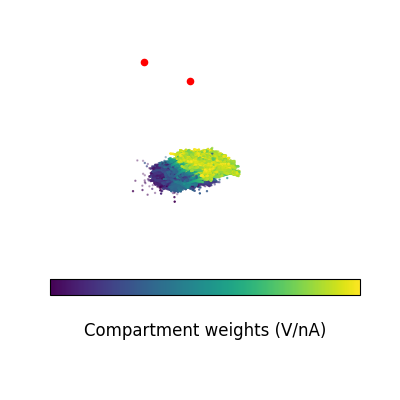

In [67]:
from matplotlib.gridspec import GridSpec


import types

plt.rcParams['axes.formatter.useoffset'] = False

fig = plt.figure(figsize=(4,4))

ax1 = fig.add_subplot(1,1,1,projection='3d')

#####
# Iterates through the node ids of the neurons whose positions have been loaded
# Plots the positions in 3d, colored according to the compartment weights for EEG
for i in ids[:100]:
    
    if i in FLshort:
        region = FLshort
        marker = 'o'
        scaleFac = scaleFacFl
        color = 'C0'
    elif i in HLshort:
        region = HLshort
        marker = 'v'
        scaleFac = scaleFacHl
        color='C1'
    elif i in ULPshort:
        region = ULPshort
        marker ='s'
        scaleFac = scaleFacULp
        color='C2'
        
    index = np.where(region==i)[0][0]
    
    scale = scaleFac[index]
    
    p = getNeuronSegmentMidpts(allPositions[i]).values
        
    im = ax1.scatter(p[0],p[1],p[2],marker=marker,c=scale,s=.5)#,vmin=0,vmax=5e-9)
    
ax1.view_init(elev=9., azim=-85)

# Plots locations of electrodes
ax1.scatter(eeg[0],eeg[1],eeg[2],c='r',s=20)
ax1.scatter(returnElectrode[0],returnElectrode[1],returnElectrode[2],c='r',s=20) 

ax1.set_xlim((2801.1161576783625, 5500))
ax1.set_ylim((0, 1883.8635116069354))
ax1.set_zlim((-4332.110601382281, 914.4962633882312))


ax1.axis('off')

cb = plt.colorbar(im,fraction=0.25,location='bottom')

cb.set_label(label='Compartment weights (V/nA)',labelpad=20)
cb.set_ticks([])
#####

plt.savefig('figures/neurons.png',dpi=600)